In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

In [2]:
# Defining a function to calculate Intersection over Union (IoU)
def iou(box1, box2, is_pred=True):
    if is_pred:
        # IoU score for prediction and label
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format
        
        # Box coordinates of prediction
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

        # Box coordinates of ground truth
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2

        # Get the coordinates of the intersection rectangle
        x1 = torch.max(b1_x1, b2_x1)
        y1 = torch.max(b1_y1, b2_y1)
        x2 = torch.min(b1_x2, b2_x2)
        y2 = torch.min(b1_y2, b2_y2)
        # Make sure the intersection is at least 0
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

        # Calculate the union area
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
        union = box1_area + box2_area - intersection

        # Calculate the IoU score
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon)

        # Return IoU score
        return iou_score
    
    else:
        # IoU score based on width and height of bounding boxes
        
        # Calculate intersection area
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * \
                            torch.min(box1[..., 1], box2[..., 1])

        # Calculate union area
        box1_area = box1[..., 0] * box1[..., 1]
        box2_area = box2[..., 0] * box2[..., 1]
        union_area = box1_area + box2_area - intersection_area

        # Calculate IoU score
        iou_score = intersection_area / union_area

        # Return IoU score
        return iou_score

# Non-maximum suppression function to remove overlapping bounding boxes
def nms(bboxes, iou_threshold, threshold):
    # Filter out bounding boxes with confidence below the threshold.
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort the bounding boxes by confidence in descending order.
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Initialize the list of bounding boxes after non-maximum suppression.
    bboxes_nms = []

    while bboxes:
        # Get the first bounding box.
        first_box = bboxes.pop(0)

        # Iterate over the remaining bounding boxes.
        for box in bboxes:
        # If the bounding boxes do not overlap or if the first bounding box has
        # a higher confidence, then add the second bounding box to the list of
        # bounding boxes after non-maximum suppression.
            if box[0] != first_box[0] or iou(
                torch.tensor(first_box[2:]),
                torch.tensor(box[2:]),
            ) < iou_threshold:
                # Check if box is not in bboxes_nms
                if box not in bboxes_nms:
                    # Add box to bboxes_nms
                    bboxes_nms.append(box)

    # Return bounding boxes after non-maximum suppression.
    return bboxes_nms

# Function to convert cells to bounding boxes
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True):
    # Batch size used on predictions
    batch_size = predictions.shape[0]
    # Number of anchors
    num_anchors = len(anchors)
    # List of all the predictions
    box_predictions = predictions[..., 1:5]

    # If the input is predictions then we will pass the x and y coordinate
    # through sigmoid function and width and height to exponent function and
    # calculate the score and best class.
    if is_predictions:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(
            box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    
    # Else we will just calculate scores and best class.
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    # Calculate cell indices
    cell_indices = (
        torch.arange(s)
        .repeat(predictions.shape[0], 3, s, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )

    # Calculate x, y, width and height with proper scaling
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / s * (box_predictions[..., 1:2] +
                 cell_indices.permute(0, 1, 3, 2, 4))
    width_height = 1 / s * box_predictions[..., 2:4]

    # Concatinating the values and reshaping them in
    # (BATCH_SIZE, num_anchors * S * S, 6) shape
    converted_bboxes = torch.cat(
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6)

    # Returning the reshaped and converted bounding box list
    return converted_bboxes.tolist()

# Function to plot images with bounding boxes and class labels
def plot_image(image, boxes):
    # Getting the color map from matplotlib
    colour_map = plt.get_cmap("tab20b")
    # Getting 20 different colors from the color map for 20 different classes
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))]

    # Reading the image with OpenCV
    img = np.array(image)
    # Getting the height and width of the image
    h, w, _ = img.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Add image to plot
    ax.imshow(img)

    # Plotting the bounding boxes and labels over the image
    for box in boxes:
        # Get the class from the box
        class_pred = box[0]
        # Get the center x and y coordinates
        box = box[2:]
        # Get the upper left corner coordinates
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        # Create a Rectangle patch with the bounding box
        rect = patches.Rectangle(
            (upper_left_x * w, upper_left_y * h),
            box[2] * w,
            box[3] * h,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add class name to the patch
        plt.text(
            upper_left_x * w,
            upper_left_y * h,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    # Display the plot
    plt.show()
    
# Function to save checkpoint
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("==> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

# Function to load checkpoint
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("==> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [3]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load and save model variable
load_model = False
save_model = True

# model checkpoint file name
checkpoint_file = "checkpoint.pth.tar"

# Anchor boxes for each feature map scaled between 0 and 1
# 3 feature maps at 3 different scales based on YOLOv3 paper
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

# Batch size for training
batch_size = 32

# Learning rate for training
leanring_rate = 1e-5

# Number of epochs for training
epochs = 20

# Image size
image_size = 416

# Grid cell sizes
s = [image_size // 32, image_size // 16, image_size // 8]

# Class labels
class_labels = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [4]:
# Create a dataset class to load the images and labels from the folder
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, image_dir, label_dir, anchors, 
        image_size=416, grid_sizes=[13, 26, 52],
        num_classes=20, transform=None
    ):
        # Read the csv file with image names and labels
        self.label_list = pd.read_csv(csv_file)
        # Image and label directories
        self.image_dir = image_dir
        self.label_dir = label_dir
        # Image size
        self.image_size = image_size
        # Transformations
        self.transform = transform
        # Grid sizes for each scale
        self.grid_sizes = grid_sizes
        # Anchor boxes
        self.anchors = torch.tensor(
            anchors[0] + anchors[1] + anchors[2])
        # Number of anchor boxes 
        self.num_anchors = self.anchors.shape[0]
        # Number of anchor boxes per scale
        self.num_anchors_per_scale = self.num_anchors // 3
        # Number of classes
        self.num_classes = num_classes
        # Ignore IoU threshold
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, idx):
        # Getting the label path
        label_path = os.path.join(self.label_dir, self.label_list.iloc[idx, 1])
        # We are applying roll to move class label to the last column
        # 5 columns: x, y, width, height, class_label
        bboxes = np.roll(np.loadtxt(fname=label_path,
                         delimiter=" ", ndmin=2), 4, axis=1).tolist()
        
        # Getting the image path
        img_path = os.path.join(self.image_dir, self.label_list.iloc[idx, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        # Albumentations augmentations
        if self.transform:
            augs = self.transform(image=image, bboxes=bboxes)
            image = augs["image"]
            bboxes = augs["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        # target : [probabilities, x, y, width, height, class_label]
        targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6))
                   for s in self.grid_sizes]
        
        # Identify anchor box and cell for each bounding box
        for box in bboxes:
            # Calculate iou of bounding box with anchor boxes
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors, is_pred=False)
            # Selecting the best anchor box
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box

            # At each scale, assigning the bounding box to the best matching anchor box
            has_anchor = [False] * 3
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                
                # Identifying the grid size for the scale
                s = self.grid_sizes[scale_idx]
                
                # Identifying the cell to which the bounding box belongs
                i, j = int(s * y), int(s * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                
                # Check if the anchor box is already assigned
                if not anchor_taken and not has_anchor[scale_idx]:

                    # Set the probability to 1
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1

                    # Calculating the center of the bounding box relative to the cell
                    x_cell, y_cell = s * x - j, s * y - i 

                    # Calculating the width and height of the bounding box relative to the cell
                    width_cell, height_cell = (width * s, height * s)

                    # Idnetify the box coordinates
                    box_coordinates = torch.tensor(
                                        [x_cell, y_cell, width_cell, height_cell]
                                    )

                    # Assigning the box coordinates to the target
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates

                    # Assigning the class label to the target
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)

                    # Set the anchor box as assigned for the scale
                    has_anchor[scale_idx] = True

                # If the anchor box is already assigned, check if the IoU is greater than the threshold
                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    # Set the probability to -1 to ignore the anchor box
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1

        # Return the image and the target
        return image, tuple(targets)

In [5]:
# Transform for training
train_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=image_size),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT
        ),
        # Random color jittering
        A.ColorJitter(
            brightness=0.5, contrast=0.5,
            saturation=0.5, hue=0.5, p=0.5
        ),
        # Flip the image horizontally
        A.HorizontalFlip(p=0.5),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ], 
    # Augmentation for bounding boxes
    bbox_params=A.BboxParams(
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[]
                )
)

# Transform for testing
test_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=image_size),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT
        ),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams(
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[]
                )
)

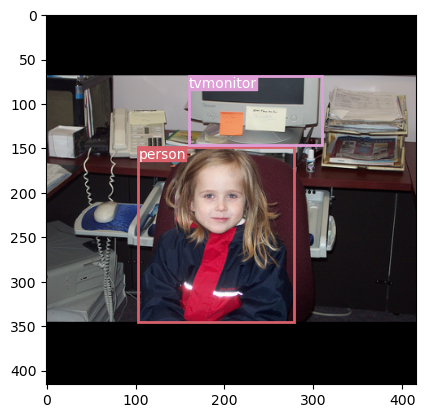

In [6]:
# Creating a dataset object
dataset = Dataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
    image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform
)

# Creating a dataloader object
loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
)

# Defining the grid size and the scaled anchors
GRID_SIZE = [13, 26, 52]
scaled_anchors = torch.tensor(ANCHORS) / (
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
)

# Getting a batch from the dataloader
x, y = next(iter(loader))

# Getting the boxes coordinates from the labels
# and converting them into bounding boxes without scaling
boxes = []
for i in range(y[0].shape[1]):
    anchor = scaled_anchors[i]
    boxes += convert_cells_to_bboxes(
               y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor
             )[0]

# Applying non-maximum suppression
boxes = nms(boxes, iou_threshold=1, threshold=0.7)

# Plotting the image with the bounding boxes
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

In [7]:
# Defining CNN Block
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)
        self.use_batch_norm = use_batch_norm

    def forward(self, x):
        # Applying convolution
        x = self.conv(x)
        # Applying BatchNorm and activation if needed
        if self.use_batch_norm:
            x = self.bn(x)
            return self.activation(x)
        else:
            return x

In [8]:
# Defining residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        
        # Defining all the layers in a list and adding them based on number of 
        # repeats mentioned in the design
        res_layers = []
        for _ in range(num_repeats):
            res_layers += [
                nn.Sequential(
                    nn.Conv2d(channels, channels // 2, kernel_size=1),
                    nn.BatchNorm2d(channels // 2),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(channels),
                    nn.LeakyReLU(0.1)
                )
            ]
        self.layers = nn.ModuleList(res_layers)
        self.use_residual = use_residual
        self.num_repeats = num_repeats
    
    # Defining forward pass
    def forward(self, x):
        for layer in self.layers:
            residual = x
            x = layer(x)
            if self.use_residual:
                x = x + residual
        return x

In [9]:
# Defining scale prediction class
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Defining the layers in the network
        self.pred = nn.Sequential(
            nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*in_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(2*in_channels, (num_classes + 5) * 3, kernel_size=1),
        )
        self.num_classes = num_classes
    
	# Defining the forward pass and reshaping the output to the desired output 
    # format: (batch_size, 3, grid_size, grid_size, num_classes + 5)
    def forward(self, x):
        output = self.pred(x)
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3))
        output = output.permute(0, 1, 3, 4, 2)
        return output

In [10]:
# Class for defining YOLOv3 model
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels

        # Layers list for YOLOv3
        self.layers = nn.ModuleList([
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1),
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1),
            ResidualBlock(64, num_repeats=1),
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1),
            ResidualBlock(128, num_repeats=2),
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1),
            ResidualBlock(256, num_repeats=8),
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1),
            ResidualBlock(512, num_repeats=8),
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1),
            ResidualBlock(1024, num_repeats=4),
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
            ResidualBlock(1024, use_residual=False, num_repeats=1),
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
            ScalePrediction(512, num_classes=num_classes),
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2),
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0),
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
            ResidualBlock(512, use_residual=False, num_repeats=1),
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
            ScalePrediction(256, num_classes=num_classes),
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2),
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0),
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1),
            ResidualBlock(256, use_residual=False, num_repeats=1),
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0),
            ScalePrediction(128, num_classes=num_classes)
        ])
    
    # Forward pass for YOLOv3 with route connections and scale predictions
    def forward(self, x):
        outputs = []
        route_connections = []

        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)
            
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        return outputs

In [11]:
# Testing YOLO v3 model
if __name__ == "__main__":
    # Setting number of classes and image size
    num_classes = 20
    IMAGE_SIZE = 416

    # Creating model and testing output shapes
    model = YOLOv3(num_classes=num_classes)
    x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))
    out = model(x)
    print(out[0].shape)
    print(out[1].shape)
    print(out[2].shape)

    # Asserting output shapes
    assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
    assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
    assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
    print("Output shapes are correct!")

torch.Size([1, 3, 13, 13, 25])
torch.Size([1, 3, 26, 26, 25])
torch.Size([1, 3, 52, 52, 25])
Output shapes are correct!


In [12]:
# Defining YOLO loss class
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, pred, target, anchors):
        # Identifying which cells in target have objects 
        # and which have no objects
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # Calculating No object loss
        no_object_loss = self.bce(
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]),
        )

        
        # Reshaping anchors to match predictions
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        # Box prediction confidence
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]),
                               torch.exp(pred[..., 3:5]) * anchors
                            ],dim=-1)
        # Calculating intersection over union for prediction and target
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        # Calculating Object loss
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]),
                               ious * target[..., 0:1][obj])

        
        # Predicted box coordinates
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3])
        # Target box coordinates
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors)
        # Calculating box coordinate loss
        box_loss = self.mse(pred[..., 1:5][obj],
                            target[..., 1:5][obj])

        
        # Claculating class loss
        class_loss = self.cross_entropy((pred[..., 5:][obj]),
                                   target[..., 5][obj].long())

        # Total loss
        return (
            box_loss
            + object_loss
            + no_object_loss
            + class_loss
        )

In [13]:
# Define the train function to train the model
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    # Creating a progress bar
    progress_bar = tqdm(loader, leave=True)

    # Initializing a list to store the losses
    losses = []

    # Iterating over the training data
    for _, (x, y) in enumerate(progress_bar):
        x = x.to(device)
        y0, y1, y2 = (
            y[0].to(device),
            y[1].to(device),
            y[2].to(device),
        )

        with torch.cuda.amp.autocast():
            # Getting the model predictions
            outputs = model(x)
            # Calculating the loss at each scale
            loss = (
                  loss_fn(outputs[0], y0, scaled_anchors[0])
                + loss_fn(outputs[1], y1, scaled_anchors[1])
                + loss_fn(outputs[2], y2, scaled_anchors[2])
            )

        # Add the loss to the list
        losses.append(loss.item())

        # Reset gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        scaler.scale(loss).backward()

        # Optimization step
        scaler.step(optimizer)

        # Update the scaler for next iteration
        scaler.update()

        # update progress bar with loss
        mean_loss = sum(losses) / len(losses)
        progress_bar.set_postfix(loss=mean_loss)

In [14]:
# Creating the model from YOLOv3 class
model = YOLOv3().to(device)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr = leanring_rate)

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Defining the train dataset
train_dataset = Dataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
    image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=train_transform
)

# Defining the train data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 2,
    shuffle = True,
    pin_memory = True,
)

# Scaling the anchors
scaled_anchors = (
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
).to(device)

# Training the model
for e in range(1, epochs+1):
    print("Epoch:", e)
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    # Saving the model
    if save_model:
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 1


100%|██████████| 518/518 [05:53<00:00,  1.47it/s, loss=10.7]


==> Saving checkpoint
Epoch: 2


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=8.83]


==> Saving checkpoint
Epoch: 3


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=8.15]


==> Saving checkpoint
Epoch: 4


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=7.64]


==> Saving checkpoint
Epoch: 5


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=7.2] 


==> Saving checkpoint
Epoch: 6


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=6.79]


==> Saving checkpoint
Epoch: 7


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=6.46]


==> Saving checkpoint
Epoch: 8


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=6.09]


==> Saving checkpoint
Epoch: 9


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=5.79]


==> Saving checkpoint
Epoch: 10


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=5.49]


==> Saving checkpoint
Epoch: 11


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=5.22]


==> Saving checkpoint
Epoch: 12


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=4.99]


==> Saving checkpoint
Epoch: 13


100%|██████████| 518/518 [05:45<00:00,  1.50it/s, loss=4.76]


==> Saving checkpoint
Epoch: 14


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=4.5] 


==> Saving checkpoint
Epoch: 15


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=4.31]


==> Saving checkpoint
Epoch: 16


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=4.04]


==> Saving checkpoint
Epoch: 17


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=3.81]


==> Saving checkpoint
Epoch: 18


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=3.61]


==> Saving checkpoint
Epoch: 19


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=3.37]


==> Saving checkpoint
Epoch: 20


100%|██████████| 518/518 [05:44<00:00,  1.50it/s, loss=3.2] 


==> Saving checkpoint


==> Loading checkpoint


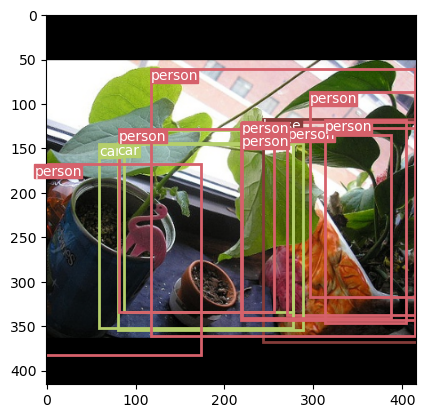

In [15]:
# Taking a sample image and testing the model

# Setting the load_model to True
load_model = True

# Defining the model, optimizer, loss function and scaler
model = YOLOv3().to(device)
optimizer = optim.Adam(model.parameters(), lr = leanring_rate)
loss_fn = YOLOLoss()
scaler = torch.cuda.amp.GradScaler()

# Loading the checkpoint
if load_model:
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate)

# Defining the test dataset and data loader
test_dataset = Dataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv",
    image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 1,
    num_workers = 2,
    shuffle = True,
)

# Getting a sample image from the test data loader
x, y = next(iter(test_loader))
x = x.to(device)

model.eval()
with torch.no_grad():
    # Getting the model predictions
    output = model(x)
    # Getting the bounding boxes from the predictions
    bboxes = [[] for _ in range(x.shape[0])]
    anchors = (
            torch.tensor(ANCHORS)
                * torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
            ).to(device)

    # Getting bounding boxes for each scale
    for i in range(3):
        batch_size, A, S, _, _ = output[i].shape
        anchor = anchors[i]
        boxes_scale_i = convert_cells_to_bboxes(
                            output[i], anchor, s=S, is_predictions=True
                        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box
model.train()

# Plotting the image with bounding boxes for each image in the batch
for i in range(batch_size):
    # Applying non-max suppression to remove overlapping bounding boxes
    nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6)
    # Plotting the image with bounding boxes
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)